# Big Mart sale prediction
### In this project  Given the Store Location, Area, Size and other paramseters. Predict the overall revenue/Sale generation of the Store.By analyzing these factors, we will develop a regression model to estimate the revenue generation of store.It is very helpful for those who  are opening a new Store at a particular location. 

In [1]:
#Importing the Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
import math
# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

### Data Collection and Processing:
After loading the dataset, we need to conduct an initial examination to understand its structure and contents. This includes identifying missing values, duplicate entries, and any other inconsistencies.

In [2]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv("Train.csv")

In [3]:
#first 5 rows of data set
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [5]:
# getting some information about the dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:

###### Item_Identifier
###### Item_Fat_Content
###### Item_Type
###### Outlet_Identifier
###### Outlet_Size
###### Outlet_Location_Type
###### Outlet_Type

[ ]


In [6]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### We can see that our data has some missing values. We start our data cleaning process.


# Data cleaning

## 1.handlibg missing or null values

In [7]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [8]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [9]:
# mode of "Outlet_Size" column
big_mart_data['Outlet_Size'].mode()


0    Medium
Name: Outlet_Size, dtype: object

In [10]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()))
print(mode_of_Outlet_size)
miss_values = big_mart_data['Outlet_Size'].isnull()   
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [11]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## 2.handle outliers

In [12]:
from scipy import stats
z_scores = np.abs(stats.zscore(big_mart_data.select_dtypes(include=[np.number])))
# Define threshold (e.g., Z-score > 3)
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).any(axis=1)
# Remove outliers or handle them (e.g., replace with mean)
data_cleaned = big_mart_data[~outliers]

# Verify the shape of the cleaned data
print(data_cleaned.shape)
big_mart_data=data_cleaned

(8338, 12)


##### Using Z-score provides a straightforward way to identify outliers based on their deviation from the mean

## 3.description of data and visualization

In [13]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000
mean,12.859956,0.063975,140.094906,1997.997242,2134.49012
std,4.252587,0.047386,61.925137,8.318759,1580.16083
min,4.555000,0.000000,31.290000,1985.000000,33.29000
25%,9.300000,0.026867,93.354100,1987.000000,852.22400
50%,12.857645,0.053293,141.948300,1999.000000,1794.33100
75%,16.100000,0.093308,184.784500,2004.000000,3075.99600
max,21.350000,0.220226,266.888400,2009.000000,7298.49960


### visualization of numerical data

Text(0.5, 1.0, 'Distribution of Item_Visibility')

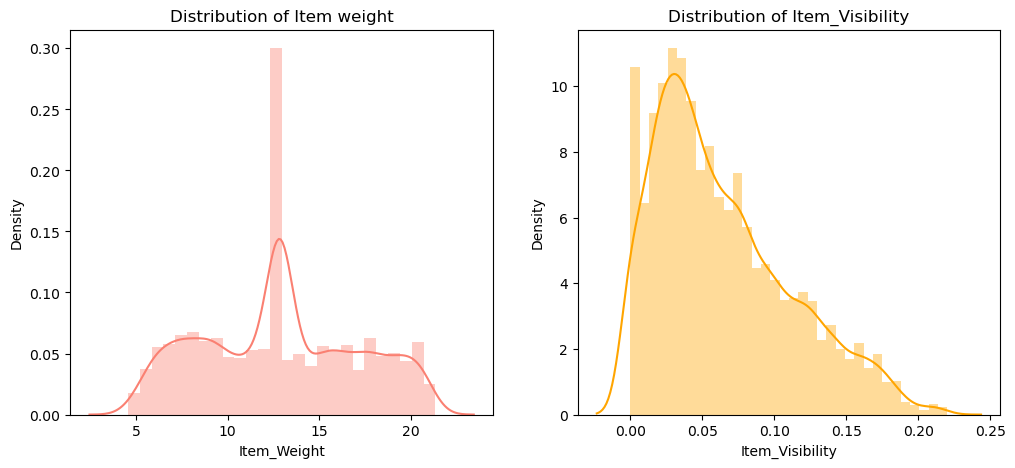

In [14]:
# Item_Weight distribution
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(big_mart_data['Item_Weight'], color = 'salmon',ax=ax)
plt.title("Distribution of Item weight")

ax=f.add_subplot(122)
sns.distplot(big_mart_data['Item_Visibility'], color = 'orange',ax=ax)
plt.title("Distribution of Item_Visibility")



###  Observations:We observe that the item weight range from 5 Kg to 20 Kg.
### Item_Visibility feature is right skewed.

Text(0.5, 1.0, 'Distribution of Item_Outlet_Sales ')

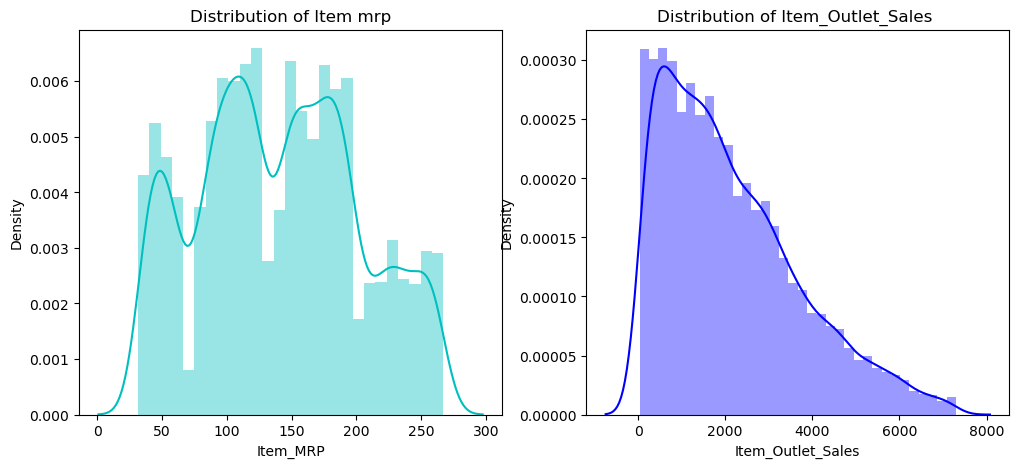

In [15]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(big_mart_data['Item_MRP'], color = 'c',ax=ax)
ax.set_title("Distribution of Item mrp")

ax=f.add_subplot(122)
sns.distplot(big_mart_data['Item_Outlet_Sales'], color = 'b',ax=ax)
ax.set_title("Distribution of Item_Outlet_Sales ")


### There are more products in the range of 100 MRP - 180 MRP in the Item_MRP feature.Item_Outlet_Sales feature is right skewed.

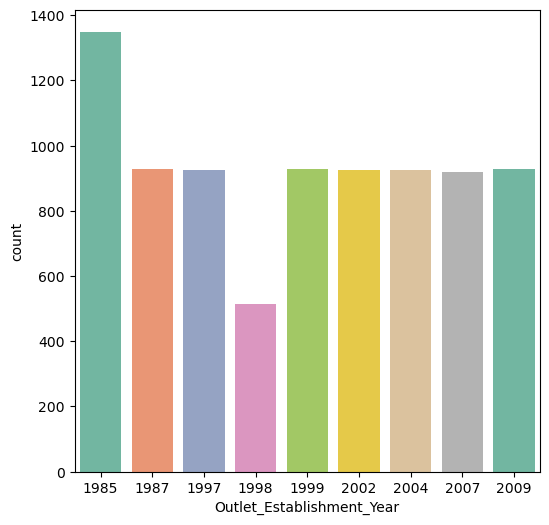

In [16]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data,palette='Set2')
plt.show()

## categorical column visualization

In [17]:
categorical_cols_to_display = [ 
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]

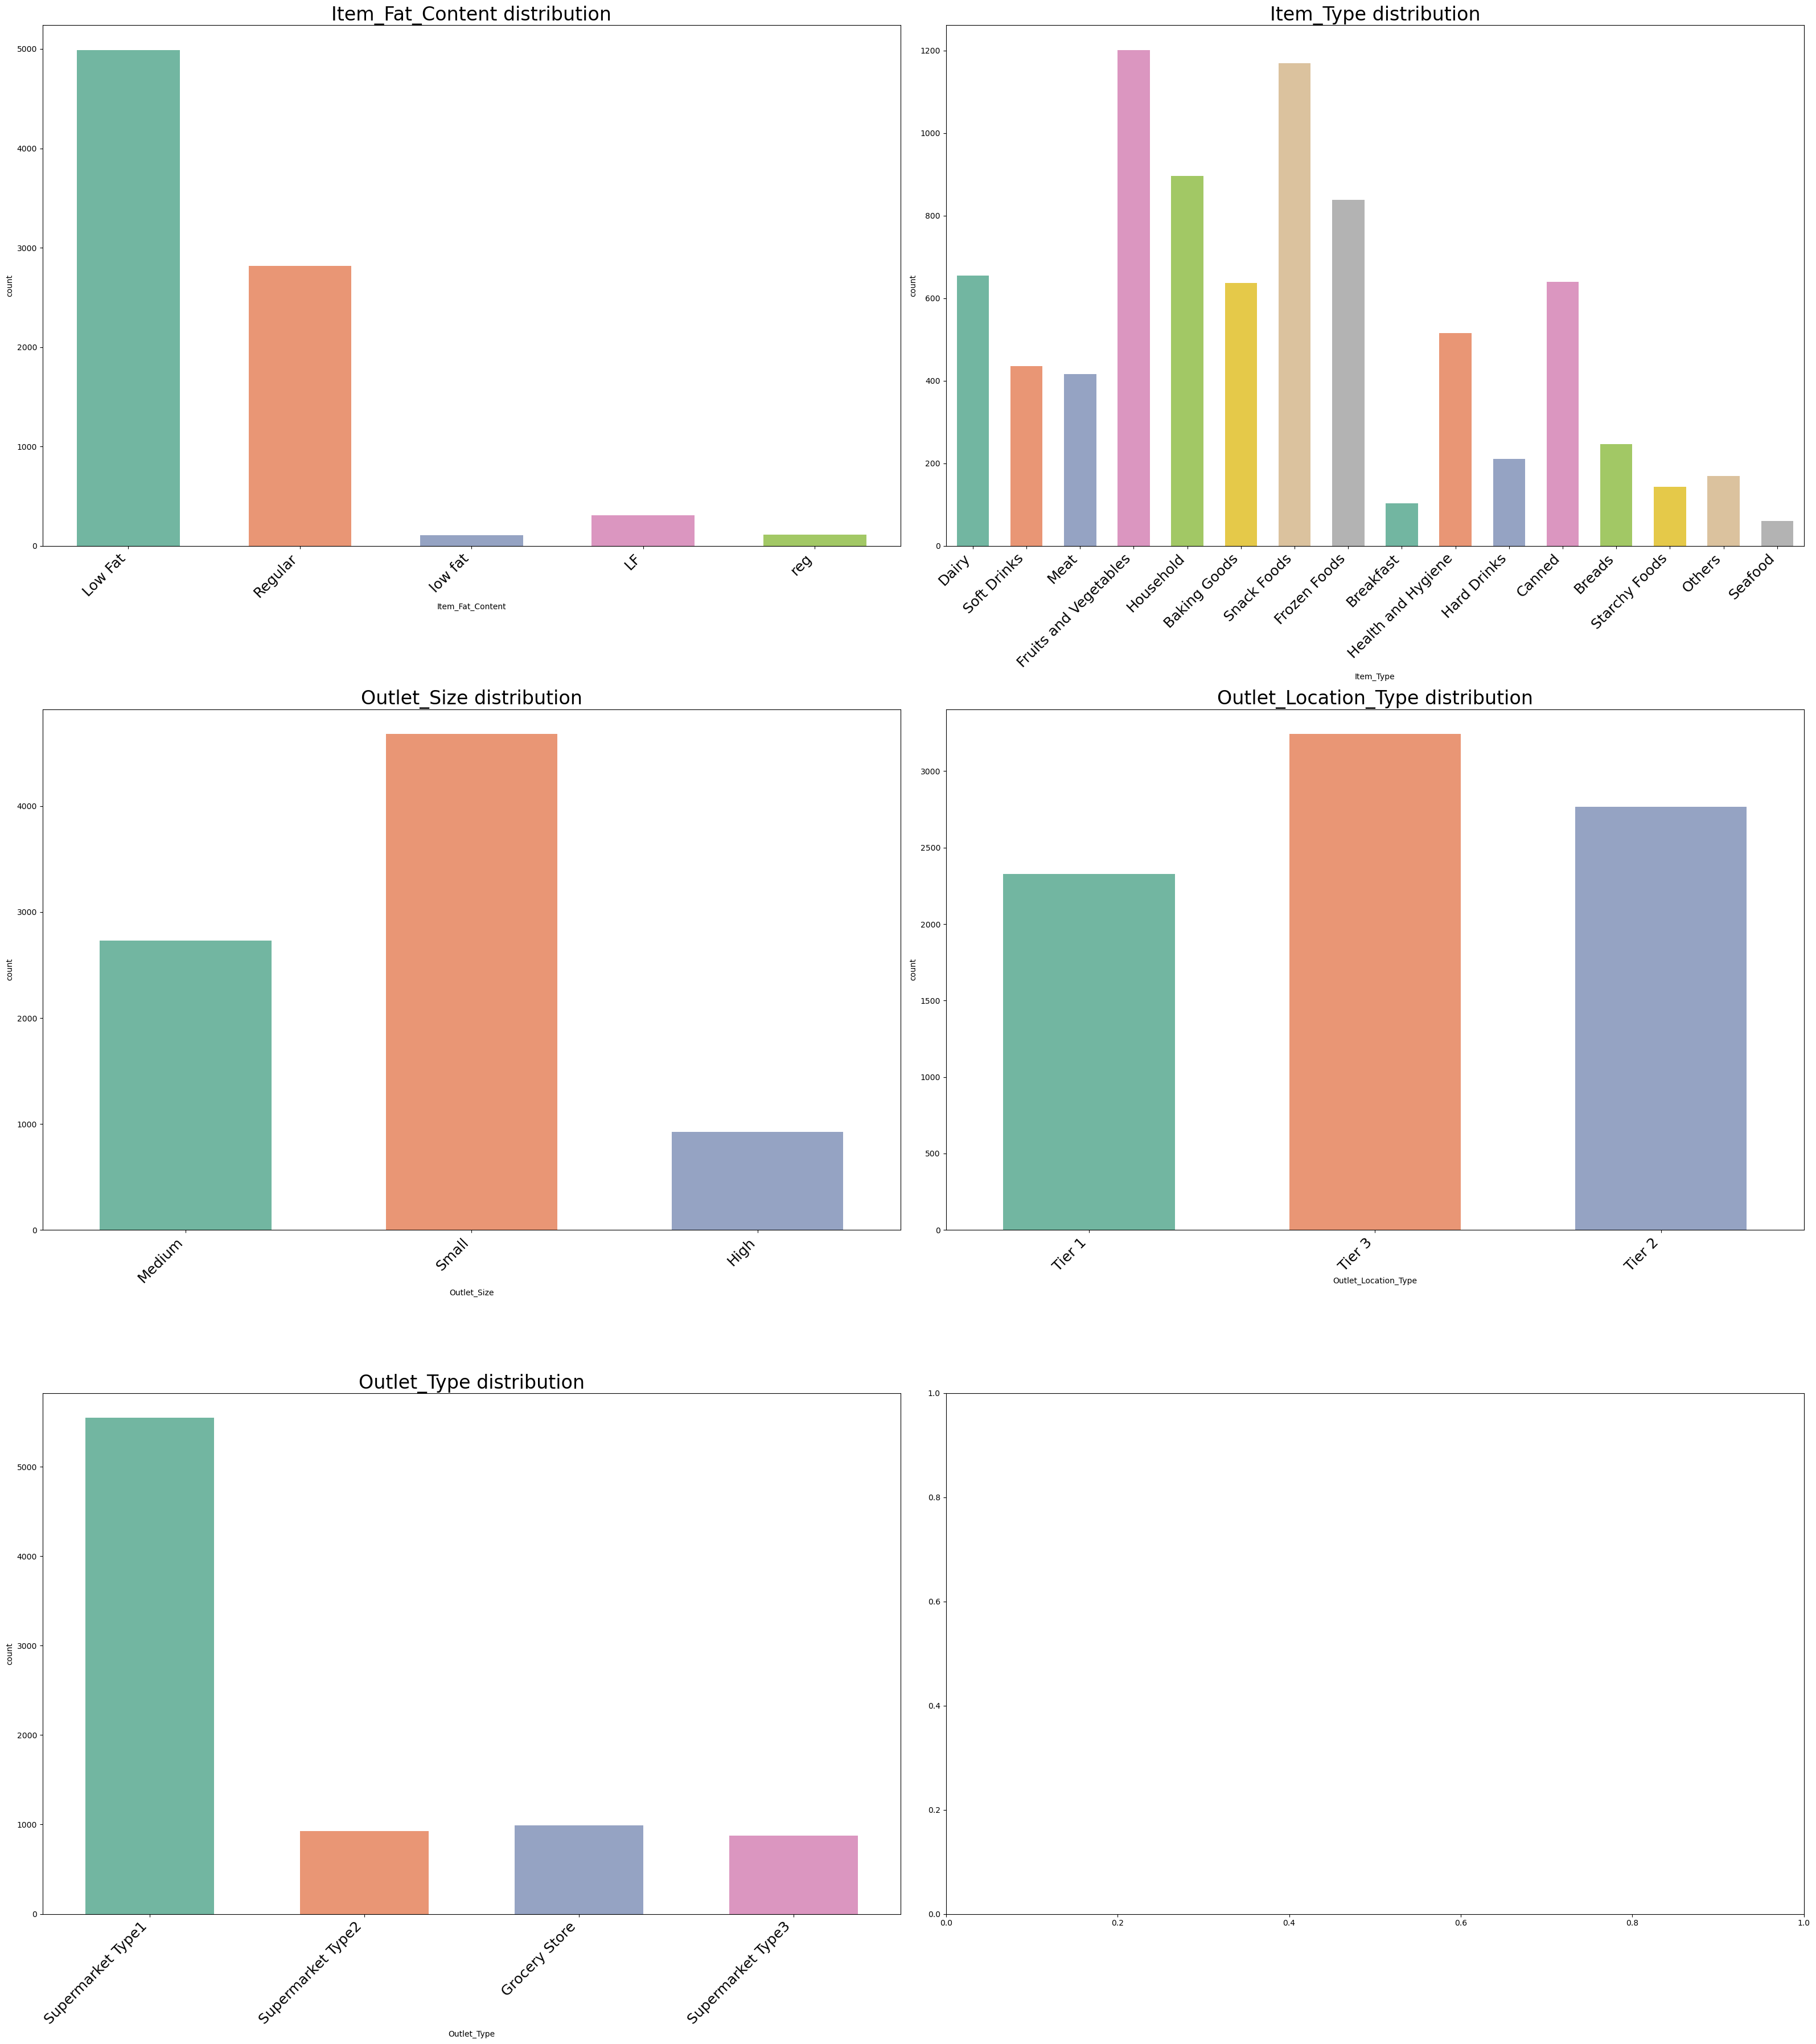

In [18]:
 f,ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=big_mart_data, x=col , ax=ax[r][c], width=0.6,palette='Set2')
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

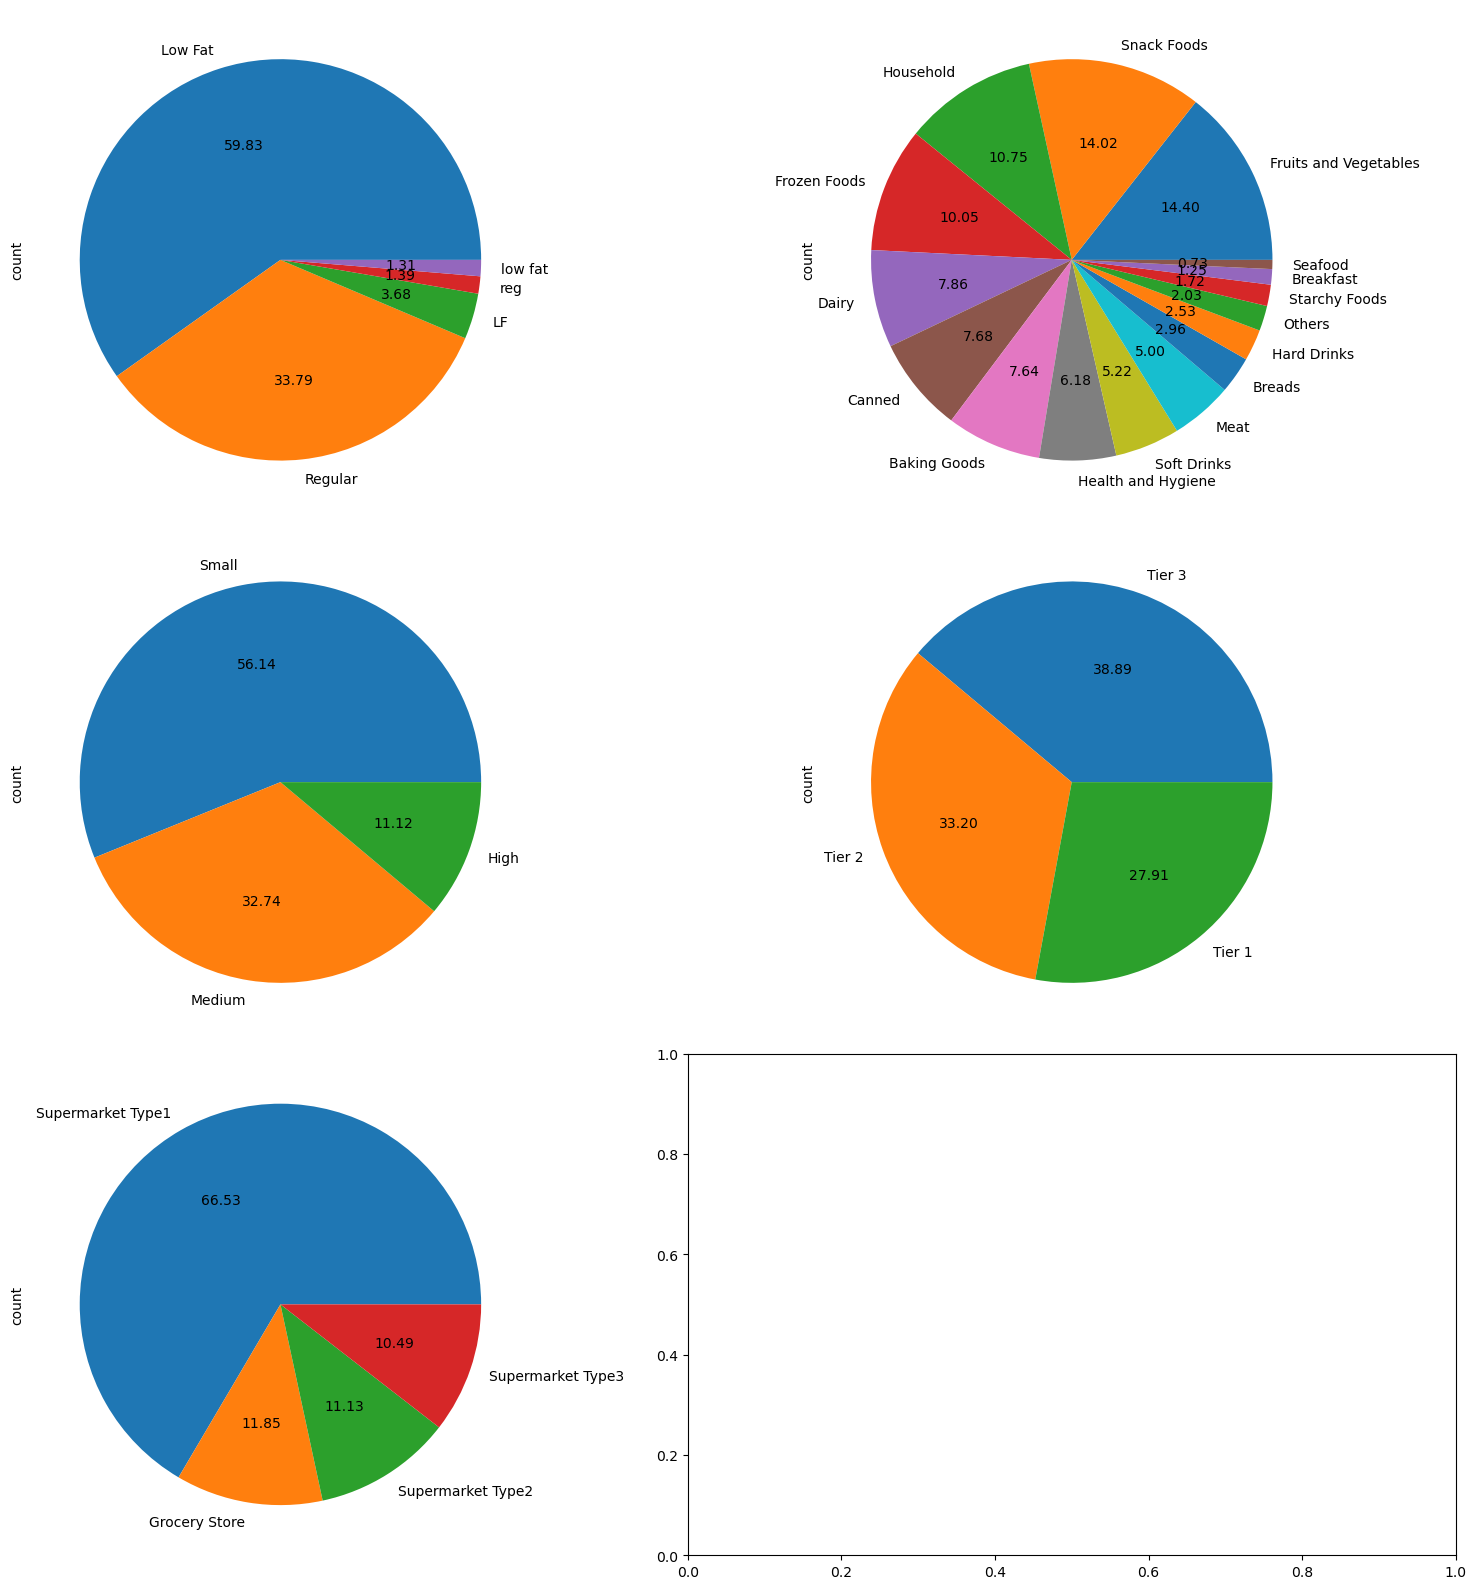

In [19]:
f,ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    big_mart_data[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    plt.tight_layout()

Observations:

The Item_Fat_Content column must be cleaned because there are some entry errors:

'Low Fat', 'low fat' and 'LF' should be the same category
Similarly 'Regular' and 'reg' should the same Another remarq in this column is that 'Low Fat' item category is greater than 'Regular' one.
There are 16 different categories in the the Item_type feature. I think it's a lot. May be in the feature engineering section we can try to group them into categories. For example grouping:

'Soft Drinks' and 'Hard Drinks' into a 'Drinks' category or
'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' into a 'Foods' category.


## 4.Data encoding

In [20]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    4989
Regular    2817
LF          307
reg         116
low fat     109
Name: count, dtype: int64

In [21]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [22]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5405
Regular    2933
Name: count, dtype: int64

In [23]:
encoder = LabelEncoder()
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])
big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

## multivariate analysis

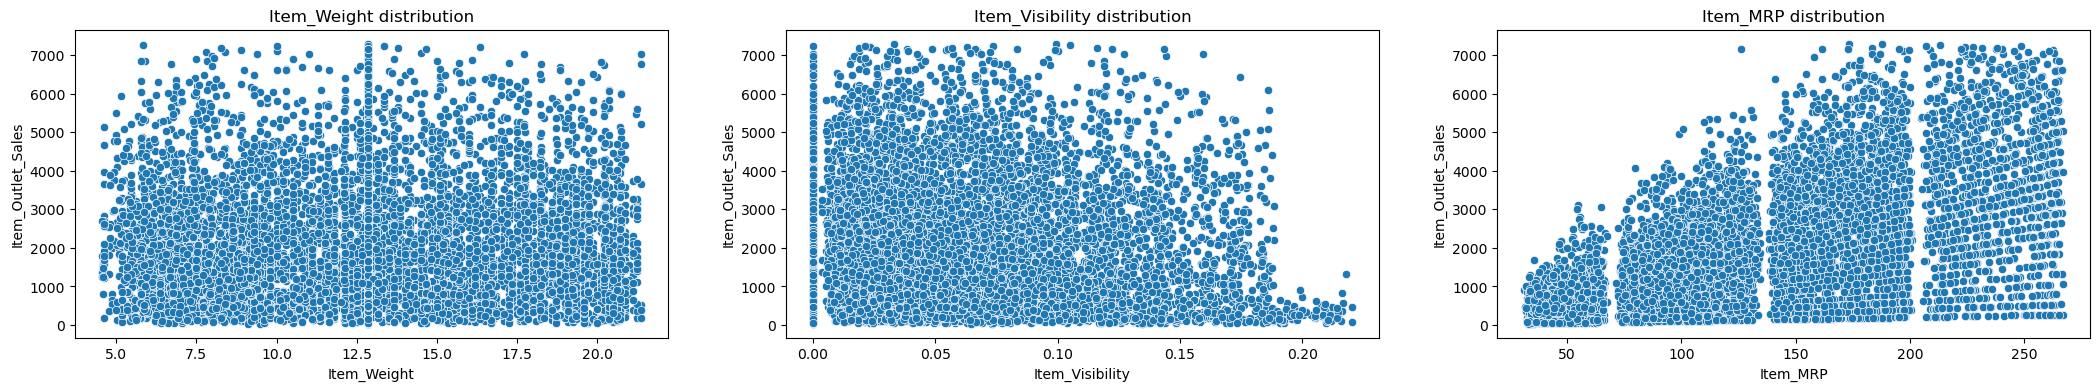

In [24]:
f,ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=big_mart_data,x=col, y=big_mart_data['Item_Outlet_Sales'], ax=ax[index])
    ax[index].set_title(f'{col} distribution')

<Axes: >

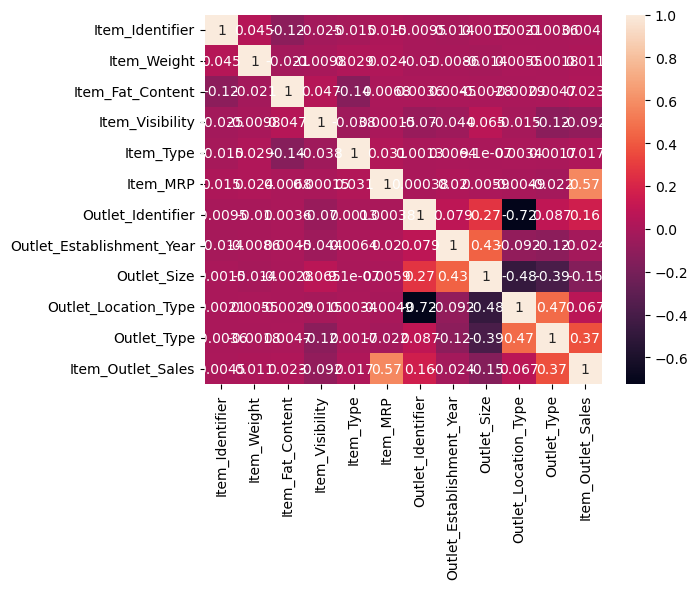

In [25]:
sns.heatmap(big_mart_data.corr(), annot=True)

### Splitting features and Target

In [26]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [27]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8338, dtype: float64



### Splitting the data into Training data & Testing Data

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [29]:
print(X.shape, X_train.shape, X_test.shape)

(8338, 11) (6670, 11) (1668, 11)


# MODELE TRAINING AND EVALUATION

### Linear regression

In [30]:
from  sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, Y_train)

LinearRegression()

In [32]:
# prediction on training data
linear_training_data_prediction = lin_reg_model.predict(X_train)
# R squared Value
r2_train = r2_score(Y_train, linear_training_data_prediction)
print('R Squared value of training data = ', r2_train)
# prediction on test data
linear_test_data_prediction = lin_reg_model.predict(X_test)
# R squared Value
r2_test = r2_score(Y_test, linear_test_data_prediction)
print('R Squared value testing set= ', r2_test)

R Squared value of training data =  0.4926831212354984
R Squared value testing set=  0.488687635920785


In [33]:
# Evaluation
lin_reg_mse  = mean_squared_error(Y_test ,linear_test_data_prediction )
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(Y_test, linear_test_data_prediction )

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1110.4899228320987
R2 Score         ----> 0.488687635920785


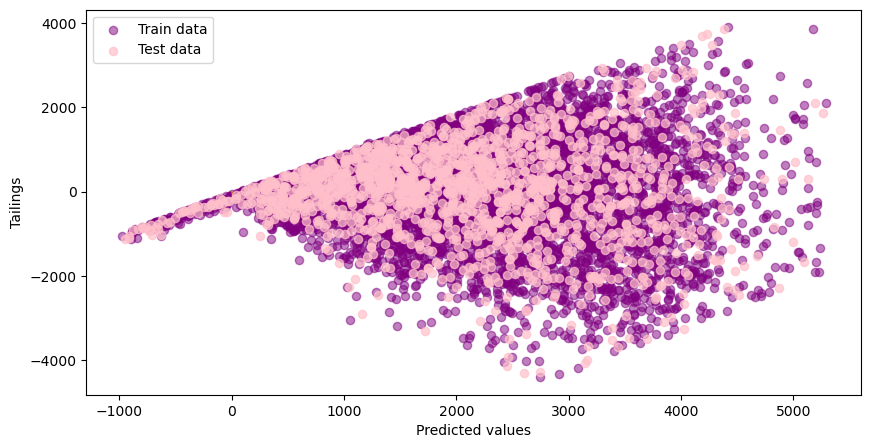

In [34]:
plt.figure(figsize=(10,5))

plt.scatter(linear_training_data_prediction,linear_training_data_prediction - Y_train,
          c = 'purple', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(linear_test_data_prediction,linear_test_data_prediction- Y_test,
          c = 'pink', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -2, xmax = 3, lw = 2, color = 'orange')
plt.show()

### XG boost

In [35]:
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [37]:
# prediction on training data
xgboost_training_data_prediction = regressor.predict(X_train)
# R squared Value
r2_train = r2_score(Y_train, xgboost_training_data_prediction)
print('R Squared value of training data = ', r2_train)
# prediction on test data
xgboost_test_data_prediction = regressor.predict(X_test)
# R squared Value
r2_test = r2_score(Y_test, xgboost_test_data_prediction)
print('R Squared value testing set= ', r2_test)

R Squared value of training data =  0.8696229949676756
R Squared value testing set=  0.4938073417009339


In [38]:
# Evaluation
xgb_mse = mean_squared_error(Y_test ,xgboost_test_data_prediction)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(Y_test,xgboost_test_data_prediction)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1104.9163385343725
XGBoost R2 Score   ----> 0.4938073417009339


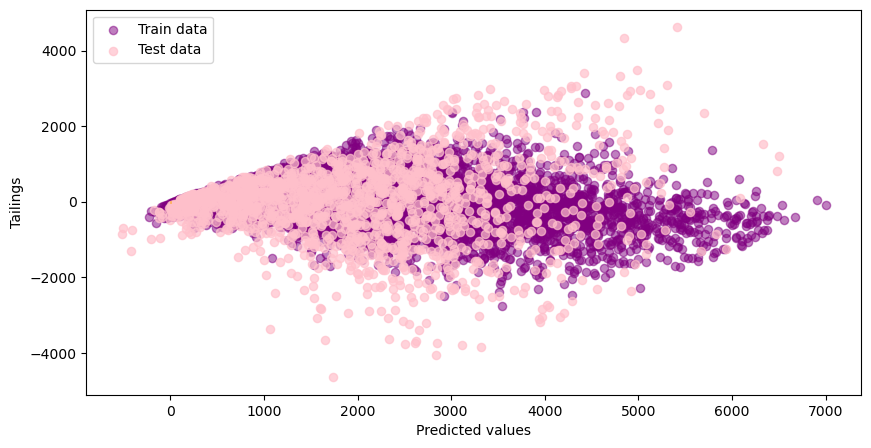

In [39]:
plt.figure(figsize=(10,5))

plt.scatter(xgboost_training_data_prediction,xgboost_training_data_prediction - Y_train,
          c = 'purple', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(xgboost_test_data_prediction,xgboost_test_data_prediction- Y_test,
          c = 'pink', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -2, xmax = 3, lw = 2, color = 'orange')
plt.show()

The model achieved an R² score of 0.493, indicating that approximately 49.3% of the variance in outlet sales can be explained by the model. On the training data, the model achieved a high R² score of 0.869 .On the test data, the model maintained good performance with an R² score of 0.493 , showcasing its ability to generalize well to unseen data. Overall, these results suggest that the model is a robust and reliable tool for predicting outlet sales based on the given features.
Thank you!